In [21]:
import tensorflow as tf
# pip install tensorflow_addons
from tensorflow_addons.optimizers import AdamW
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import matplotlib
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
matplotlib.rcParams['figure.dpi'] = 300

In [22]:
BASE_PATH = 'style_transfer'

sources = [
    {
        "subject" : "first_man_moon.jpg",
        "style"  : "arte_contemporanea.jpg"
    },
    {
        "subject": "guy.jpeg",
        "style": "urlo-munch.jpeg"
    },
    {
        "subject": "forest.jpg",
        "style": "metropolis.jpg"
    },
    {
        "subject": "pannofino.jpg",
        "style": "arte_contemporanea.jpg"
    },
    {
        "subject": "davinci_monnalisa.jpg",
        "style": "picasso.jpeg"
    },
    {
        "subject": "starry_night.jpeg",
        "style": "urlo-munch.jpeg"
    },
    {
        "subject" : "first_man_moon.jpg",
        "style"  : "castle.jpg"
    },
    {
        "subject": "child_dog.jpg",
        "style": "anime.jpg"
    },
    {
        "subject": "guy.jpeg",
        "style": "picasso.jpeg"
    },
    {
        "subject": "photo_1.jpg",
        "style": "urlo-munch.jpeg"
    },
    {
        "subject": "photo_2.jpg",
        "style": "picasso.jpeg"
    },
    {
        "subject": "photo_3.jpeg",
        "style": "dali.jpg"
    },
    {
        "subject": "guy.jpeg",
        "style": "davinci_monnalisa.jpg"
    },
    {
        "subject": "palo_del_colle.jpeg",
        "style": "starry_night.jpeg"
    },
    {
        "subject": "paris.jpeg",
        "style": "landscape_cartoon.jpg"
    },
    {
        "subject": "new-york.jpg",
        "style": "pokemon.JPG"
    },
    {
        "subject": "guy.jpeg",
        "style": "urlo-munch.jpeg"
    }
]

base_image_path = sources[0]["subject"]
style_reference_image_path = sources[0]["style"]

# N. iterazioni
iterations = 1500
# Pesi delle differenti componenti di funzione di costo
total_variation_weight = 1e-6
style_weight = 3e-6
content_weight = 5e-6

# Dimensioni delle immagini generate
width, height = tf.keras.preprocessing.image.load_img(os.path.join(BASE_PATH, base_image_path)).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

style_transfer/first_man_moon.jpg


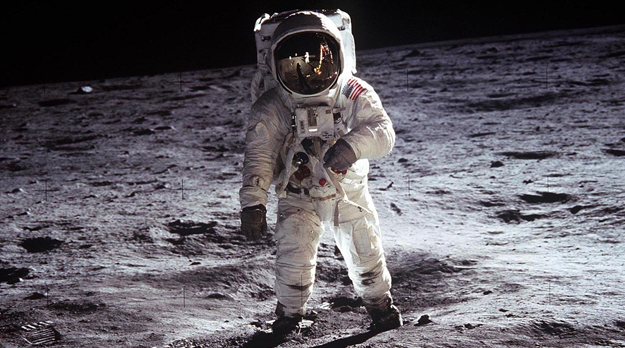



style_transfer/arte_contemporanea.jpg


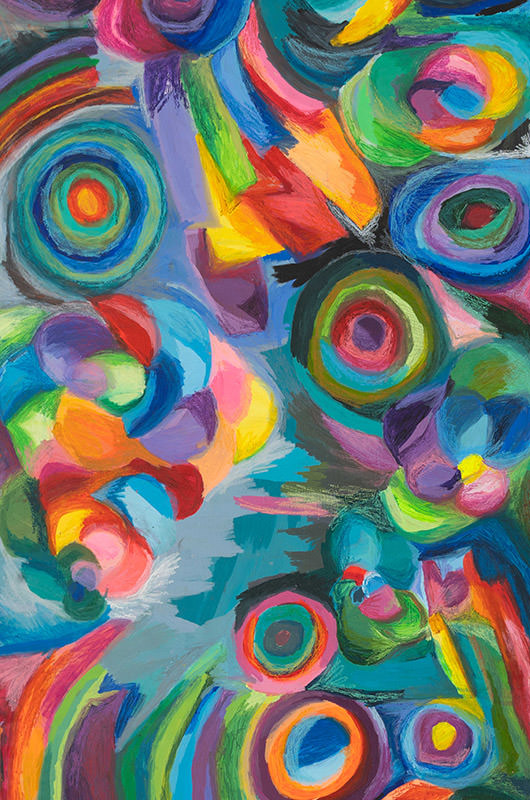

In [23]:
print(os.path.join(BASE_PATH, base_image_path))
display(Image(os.path.join(BASE_PATH, base_image_path)))

print('\n')

print(os.path.join(BASE_PATH, style_reference_image_path))
display(Image(os.path.join(BASE_PATH, style_reference_image_path)))

In [24]:
def preprocess_image(image_path):
    # Da immagine a tensore
    # Carichiamo l'immagine, la convertiamo ad array, diamo in pasto al preprocess di vgg e la trasformiamo in tensore 
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    print(f"Preprocess - Image shape: {img.shape}")
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


# https://stackoverflow.com/questions/64115145/keras-style-transfer-remove-zero-center-by-mean-pixel
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
def deprocess_image(x):
    # Da tensore a immagine
    x = x.reshape((img_nrows, img_ncols, 3))
    # RGB -> BGR 
    # "togliamo" il zero-center, sommando i valori medi del dataset ImageNet sul quale vgg è addestrato
    x[:, :, 0] += 103.939  # Media dei colori nel canale Blue
    x[:, :, 1] += 116.779  # Media dei colori nel canale Green
    x[:, :, 2] += 123.68  # # Media dei colori nel canale Red
    # preprocess_input ha una modalità di default che si chiama 'caffe' e che converte lo spazio di colori da RGB a BGR
    # Quindi poi abbiamo necessità di tornare indietro ad RGB
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [25]:
# The gram matrix of an image tensor (feature-wise outer product)
# La matrice di Gram di un tensore

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    # https://www.tensorflow.org/api_docs/python/tf/reshape
    # così ci calcoliamo la trasposta usando tf
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# Manteniamo lo stile dell'immagine di riferimento in quella generata:
# la perdita sullo stile è basata sulle matrici di Gram dell'immagine che 
# delle feature map dell'immagine di stile e dell'immagine sintetizzata
# https://www.mathsisfun.com/algebra/vectors-dot-product.html
# https://math.stackexchange.com/questions/805954/what-does-the-dot-product-of-two-vectors-represent
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    # reduce sum calcola la somma degli elementi di un tensore in una dimensione o in tutte le dimensioni
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# Calcoliamo la somma dei quadrati delle differenze fra l'immagine generata
# e quella di riferimento per il contenuto
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# Perdita totale, per mantenere l'immagine "localmente più coerente"
def total_variation_loss(x):
    # abbiamo 4 dimensioni perchè dobbiamo considerare l'axis 0 
    # che rappresenta la dimensione del batch
    # Calcola quanto divergono i pixel che si trovano in una riga con quelli che si trovano alla riga successiva
    # Gli indici sono (come sempre): dimensione del batch, righe, colonna, canali
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    # Calcola quanto divergono i pixel che si trovano in una colonna con quelli che si trovano alla colonna successiva
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    # SUPPOSIZIONE:
    # Eleviamo questa quantità per rendere la funzione derivabile. In questo modo si può usare la f nell'SGD
    # Cambiando 1.25 si cambia il "peso" di questo componente nell'immagine finale
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [26]:
# Costruiamo un modello VGG19 con i pesi pre-addestrati su ImageNet 
# e senza i livelli FC finali
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# Costruiamo un dizionario di livelli e dei loro output
for layer in model.layers:
    print("{} -> {}".format(layer.name, layer.output))

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Questo modello ritorna i valori delle attivazioni per ogni layer nella VGG19
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

input_3 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
block1_conv1 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
block1_conv2 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")
block1_pool -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
block2_conv1 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
block2_conv2 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32,

In [27]:
# Lista dei livelli da usare per la funzione di costo dello stile
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# Il livello da usare per la funzione di costo del contenuto
content_layer_name = "block5_conv2"


# Calcola l'errore totale che verrà utilizzato nella discesa del gradiente.
# L'output è un numero che è la somma della loss relativa al contenuto, loss dello stile + la total_variation_loss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    features = feature_extractor(input_tensor)

    # Inizializziamo a 0 il costo
    loss = tf.zeros(shape=())

    # Aggiungiamo il costo dell'immagine "contenuto" pesata con content_weight
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Aggiungiamo il costo dell'immagine "style" pesata con style_weight
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Aggiungiamo la loss globale pesata con total_variation_weight
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [28]:
# "spegne" la eager execution in tensorflow rendendo più veloci le operazioni
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    # GradientTape serve a ottimizzare la fase di calcolo dei vari gradienti w.r.t.
    # https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [29]:
for i in range(0, len(sources)):
    # Facciamo una discesa del gradiente "naive" per minimizzare il costo
    # Il LR è insolitamente alto: i pesi sono molto piccoli, essi vanno a moltiplicare valori fra 0 e 1, generando altri valori sempre più bassi
    # Lo mettiamo alto per non avere numeri troppo piccoli durante la discesa del gradiente 
    optimizer = AdamW(weight_decay=1e-3, learning_rate=10.)

    base_image_path = sources[i]["subject"]
    style_reference_image_path = sources[i]["style"]
    dir_name = f"{os.path.splitext(base_image_path)[0]}_{os.path.splitext(style_reference_image_path)[0]}_{iterations}"

    weights_file = os.path.join(
        BASE_PATH,
        dir_name,
        f'{os.path.splitext(base_image_path)[0]}_weights.npy'
    )

    # Se la directory in cui salvare le immagini generate non esiste, creala
    # Location -> style_transfer/{SUBJECT}_{STYLE_REFERENCE}
    if os.path.exists(os.path.join(BASE_PATH, dir_name)) is False:
        os.mkdir(
            os.path.join(
                BASE_PATH,
                dir_name
            )
        )

    # # Controlliamo se esiste il file dei pesi.
    # # Se esiste facciamo un numero di addestramenti "fake" per portarci esattamente nella condizione di salvataggio
    # # a livello di numero di iterazioni della discesa del gradiente
    if os.path.exists(weights_file):
        opt_weights = np.load(f"{weights_file}", allow_pickle=True)
        print("Loading Weights for optimizer...")
        grad_vars = feature_extractor.trainable_weights
        old_grads = [tf.zeros_like(w) for w in grad_vars]
        # Apply gradients which don't do nothing with SGD
        optimizer.apply_gradients(zip(old_grads, grad_vars))
        # Set the weights of the optimizer
        optimizer.set_weights(opt_weights)

    # Dimensioni delle immagini generate
    width, height = tf.keras.preprocessing.image.load_img(os.path.join(BASE_PATH, base_image_path)).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    base_image = preprocess_image(os.path.join(BASE_PATH, base_image_path))
    style_reference_image = preprocess_image(os.path.join(BASE_PATH, style_reference_image_path))
    combination_image = tf.Variable(preprocess_image(os.path.join(BASE_PATH, base_image_path)))

    # per ogni iterazione andiamo a fare un calcolarci l'errore e il gradiente 
    # applichiamo i gradienti trovati alla discesa del gradiente
    # ogni tot iterazioni facciamo deprocess della combination_image e la salviamo

    print(f"Immagine: {os.path.splitext(base_image_path)[0]}; Stile {os.path.splitext(style_reference_image_path)[0]}")

    for o in range(iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
        if o == 1 or o == 3 or o == 8 or o == 25 or o == 66:
            img = deprocess_image(combination_image.numpy())
            fname = os.path.splitext(base_image_path)[0] + "_at_iteration_%d.png" % o
            tf.keras.preprocessing.image.save_img(os.path.join('style_transfer', dir_name, fname), img)
        if o % 50 == 0:
            print("\rIteration %d: loss=%.2f" % (o, loss), '- learning rate:', optimizer.learning_rate.numpy(), '            ', end='')
            if (o < 2000 and o % 100 == 0) or (o >=1000 and o % 250 == 0):
                if o > 0:
                    tf.keras.backend.set_value(optimizer.learning_rate, optimizer.learning_rate.numpy() * .75)
                print()
                img = deprocess_image(combination_image.numpy())
                fname = os.path.splitext(base_image_path)[0] + "_at_iteration_%d.png" % o
                tf.keras.preprocessing.image.save_img(os.path.join('style_transfer', dir_name, fname), img)

    np.save(weights_file, optimizer.get_weights())

Preprocess - Image shape: (1, 400, 718, 3)
Preprocess - Image shape: (1, 400, 718, 3)
Preprocess - Image shape: (1, 400, 718, 3)
Immagine: first_man_moon; Stile arte_contemporanea
Iteration 0: loss=347375.97 - learning rate: 10.0             
Iteration 100: loss=5366.14 - learning rate: 10.0             
Iteration 200: loss=79849.08 - learning rate: 7.5             
Iteration 300: loss=3955.17 - learning rate: 5.625             
Iteration 400: loss=3579.59 - learning rate: 4.21875             
Iteration 500: loss=3453.01 - learning rate: 3.1640625             
Iteration 600: loss=3405.94 - learning rate: 2.3730469             
Iteration 700: loss=3404.42 - learning rate: 1.7797852             
Iteration 800: loss=3433.85 - learning rate: 1.3348389             
Iteration 900: loss=3488.90 - learning rate: 1.0011292             
Iteration 1000: loss=3568.58 - learning rate: 0.75084686             
Iteration 1100: loss=3672.21 - learning rate: 0.56313515             
Iteration 1200: loss=

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.